In [133]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import texttable as tt
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn import linear_model 
from sklearn import svm
from sklearn import neural_network

## Loading data

In [2]:
data = pd.read_csv('data/train.csv', index_col='PassengerId')

## Preprocessing

### removing unhelpful columns

First we need to preprocess the data remove unique data like the name and ticket number that may not be useful in predicting the target variable: i.e. did the passenger survive.

Here we choose to remove the columns : 
- name
- ticket number
- Cabin

In [3]:
data[0:5]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
del data.index.name # lets also remove this row with just the name on it to make things easier later

In [5]:
data[0:5]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data = data.drop(labels=['Name', 'Ticket', 'Cabin'], axis=1) # dropping name, ticket and Cabin columns

In [7]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Dealing with NaN values

Now we need to treat NaN values somehow as they can have break our learning algorithm

In [8]:
num_dropped_removing_Nans = len(data) - len(data.dropna()) # calculate number of entries we would drop if we dropped all entries containing NaN
percent_dropped_removing_Nans = 100*(len(data) - len(data.dropna()))/len(data)

print(num_dropped_removing_Nans) # dropping all rows with NaNs in them drops 708 examples
print("Percent dropped by removing NaNs: {:.2f}%".format(percent_dropped_removing_Nans))

179
Percent dropped by removing NaNs: 20.09%


Removing entries with NaNs is not a good option as it leads to loss of almost 20% of the data, we should find another way to deal with these NaN entries.

Lets take a look at some of our NaN entries

In [9]:
data_temp = data[data.isnull().any(axis=1)] # get any row that has a NaN in it
data_temp[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
6,0,3,male,NaN,0,0,8.4583,Q
18,1,2,male,NaN,0,0,13.0000,S
20,1,3,female,NaN,0,0,7.2250,C
27,0,3,male,NaN,0,0,7.2250,C
29,1,3,female,NaN,0,0,7.8792,Q


Our options are to replace NaNs with:
- A constant value that has meaning within the domain, such as 0, distinct from all other values.
- A value from another randomly selected record.
- A mean, median or mode value for the column.
- A value estimated by another predictive model.

I have tested the first 3 methods and found using the mean value to produce the best performance.

In [10]:
data = data[data.Embarked.notnull()] # remove data where embarked is null as we can't calculate a numerical value for this with the below methods

#### Here we are using scikit learns imputer to guess missing values from other data, in practise the method we are using is to calculate the mean of that column and replace NaN values with the column mean

In [11]:
imputer = preprocessing.Imputer(strategy="mean", axis=0)
data_nans_replaced = data.copy()
data_nans_replaced['Age'] = imputer.fit_transform(data_nans_replaced['Age'].reshape(-1, 1))

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


And lets look what the NaNs were replaced with 

In [12]:
data_temp = data_nans_replaced[data.isnull().any(axis=1)] # get rows of the replaced data where the rows used to contain NaNs
data_temp[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
6,0,3,male,29.642093,0,0,8.4583,Q
18,1,2,male,29.642093,0,0,13.0000,S
20,1,3,female,29.642093,0,0,7.2250,C
27,0,3,male,29.642093,0,0,7.2250,C
29,1,3,female,29.642093,0,0,7.8792,Q


Repacing these in this way may cause some issues, but we will go forward with this method for now and see how it affects the performance of our learning algorithm later by comparing performance of the learning algorithm with some of the other methods to replace NaN values.

In [13]:
data = data_nans_replaced # replace data with data where we have replaced NaNs with mean values

Lets check we really got rid of all the NaNs

In [14]:
num_dropped_removing_Nans = len(data) - len(data.dropna())
percent_dropped_removing_Nans = 100*(len(data) - len(data.dropna()))/len(data)

print(num_dropped_removing_Nans) # dropping all rows with NaNs in them drops 708 examples
print("Percent dropped by removing NaNs: {:.2f}%".format(percent_dropped_removing_Nans))

0
Percent dropped by removing NaNs: 0.00%


We did!

In [15]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Encoding categorical features

We now need to encode the categorical features into many binary features. This is nessesary because of the way the algorithm interprets numbers. If we have a categorical feature that takes values 0, 1, 2, 3, 4 it assumes the higher numbers are 'better' (e.g. 4>3) even though they are arbitrary encodings, because ultimately it is calculating values/weights/parameters to be multiplied by these feature variables to give a term which enters into the linear regression. One common way to deal with this is one-hot-encoding, where a feature N takes values 0, 1, 2 for example we would generate 3 features which takes binary values 0 or 1. An example is shown below

We have the original feature data:

| Entry        | N          |
| ------------ |:----------:|
| 0            | 1          | 
| 1            | 2          |
| 2            | 0          |
| 3            | 1          |
| 4            | 2          |
| 5            | 0          |

Which when encoded becomes:

| Entry        | N==0       | N==1       | N==2       |
| ------------ |:----------:|:----------:|:----------:|
| 0            | 0          | 1          | 0          | 
| 1            | 0          | 0          | 1          | 
| 2            | 1          | 0          | 0          | 
| 3            | 0          | 1          | 0          | 
| 4            | 0          | 0          | 1          | 
| 5            | 1          | 0          | 0          | 


Here we need some insight into the data. The categorical features are:
- pclass : the Ticket class
- sex : the gender/sex of the passenger 
- embarked : the port where the passenger embarked from
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

We encode sex with 0 or 1 and save the mapping we have used to a dictionary so we now how to transform new data we get in future.

In [16]:
data.Sex[0:5]

1      male
2    female
3    female
4    female
5      male
Name: Sex, dtype: object

In [17]:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(data.Sex.unique()) # fits a value to each unique integer value of the feature variable sex
data['Sex_numeric'] = le_sex.transform(data.Sex) # transform the data from labels to numeric

In [18]:
data.Sex_numeric[0:5] # values are now encoded numerically

1    1
2    0
3    0
4    0
5    1
Name: Sex_numeric, dtype: int64

In [19]:
le_sex.inverse_transform(data.Sex_numeric[0:5]) # and the label encoder lets us reverse this if need be

array(['male', 'female', 'female', 'female', 'male'], dtype=object)

In [20]:
le_Embarked = preprocessing.LabelEncoder()
le_Embarked.fit(data.Embarked.unique()) # fits a value to each unique integer value of the feature variable sex
data['Embarked_numeric'] = le_Embarked.transform(data.Embarked) # transform the data from labels to numeric

In [21]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric
1,0,3,male,22.0,1,0,7.2500,S,1,2
2,1,1,female,38.0,1,0,71.2833,C,0,0
3,1,3,female,26.0,0,0,7.9250,S,0,2
4,1,1,female,35.0,1,0,53.1000,S,0,2
5,0,3,male,35.0,0,0,8.0500,S,1,2


Pclass is already numeric and takes values 1 -> 3

In [22]:
data.Pclass.unique()

array([3, 1, 2])

In [23]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric
1,0,3,male,22.0,1,0,7.2500,S,1,2
2,1,1,female,38.0,1,0,71.2833,C,0,0
3,1,3,female,26.0,0,0,7.9250,S,0,2
4,1,1,female,35.0,1,0,53.1000,S,0,2
5,0,3,male,35.0,0,0,8.0500,S,1,2


Now that Pclass and Embarked take numeric integer values we can now apply the one-hot-encoding to generate binary features.

**Method 1 of one-hot-encoding**

In [24]:
enc_Embarked = preprocessing.OneHotEncoder()
encoded_column_vector = data.Embarked_numeric.values.reshape(-1,1) # gets numeric embarked data and rehsapes it to column vector

Embarked_one_hot_encoded = enc_Embarked.fit_transform(encoded_column_vector).toarray() # we now apply a fit and transform step to the data simultaneous which fits the one-hot-encoder and transforms the data to one-hot-encoded data

dfOneHot_Encoded = pd.DataFrame(Embarked_one_hot_encoded, 
columns = ["Embarked_"+le_Embarked.inverse_transform(int(i)) for i in range(Embarked_one_hot_encoded.shape[1])],
index=data.index
) # we now construct a dataframe out of this one-hot-encoded data

In [25]:
data = pd.concat([data, dfOneHot_Encoded], axis=1)
# we now add our one-hot-encoded Embarked features

In [26]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric,Embarked_C,Embarked_Q,Embarked_S
1,0,3,male,22.0,1,0,7.2500,S,1,2,0.0,0.0,1.0
2,1,1,female,38.0,1,0,71.2833,C,0,0,1.0,0.0,0.0
3,1,3,female,26.0,0,0,7.9250,S,0,2,0.0,0.0,1.0
4,1,1,female,35.0,1,0,53.1000,S,0,2,0.0,0.0,1.0
5,0,3,male,35.0,0,0,8.0500,S,1,2,0.0,0.0,1.0


**Method 2 of one-hot-encoding**

In [27]:
Pclass_lb = preprocessing.LabelBinarizer()
Pclass_one_hot_encoded = Pclass_lb.fit_transform(data.Pclass.values)

dfOneHot_Encoded = pd.DataFrame(Pclass_one_hot_encoded, 
columns = ["Pclass_"+str(int(i+1)) for i in range(Pclass_one_hot_encoded.shape[1])],
index=data.index
) # we now construct a dataframe out of this one-hot-encoded data

data = pd.concat([data, dfOneHot_Encoded], axis=1)
# we now add our one-hot-encoded Embarked features

In [28]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
1,0,3,male,22.0,1,0,7.2500,S,1,2,0.0,0.0,1.0,0,0,1
2,1,1,female,38.0,1,0,71.2833,C,0,0,1.0,0.0,0.0,1,0,0
3,1,3,female,26.0,0,0,7.9250,S,0,2,0.0,0.0,1.0,0,0,1
4,1,1,female,35.0,1,0,53.1000,S,0,2,0.0,0.0,1.0,1,0,0
5,0,3,male,35.0,0,0,8.0500,S,1,2,0.0,0.0,1.0,0,0,1


Now we have finished preprocessing our data we can extract our feature and target varaibles to be used to train, validate and test our learning algorithm.

In [29]:
y = data['Survived']
X = data.drop(['Survived'], 1)

In [30]:
X.drop(labels=['Sex', 'Pclass', 'Embarked', 'Embarked_numeric'], axis=1, inplace=True) # we drop the features that we have one-hot-encoded but not removed yet (we left these in to check the encoding had worked correctly)

In [31]:
X[0:5]

,Age,SibSp,Parch,Fare,Sex_numeric,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
1,22.0,1,0,7.2500,1,0.0,0.0,1.0,0,0,1
2,38.0,1,0,71.2833,0,1.0,0.0,0.0,1,0,0
3,26.0,0,0,7.9250,0,0.0,0.0,1.0,0,0,1
4,35.0,1,0,53.1000,0,0.0,0.0,1.0,1,0,0
5,35.0,0,0,8.0500,1,0.0,0.0,1.0,0,0,1


## [Train, Validation, Test] splitting

Now lets split our pre-processed data into a training set, cross validation set and test set with a 60/20/20 split.

In [32]:
X_temp, X_test, y_temp, y_test = model_selection.train_test_split(X, y, test_size=0.2)

X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_temp, y_temp, train_size=0.75)

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [33]:
print("Data split is as follows:")
print("-------------------------")
print("train: {} \ncross-validation: {} \ntest: {}".format(X_train.shape[0], X_cv.shape[0], X_test.shape[0]))

Data split is as follows:
-------------------------
train: 533 
cross-validation: 178 
test: 178


## First lets just predict everyone dies, no learning algorithm, to see how that goes

In [34]:
def predict(X):
    return np.zeros(X_test.shape[0])

In [35]:
prediction = predict(X_test)

In [36]:
100*sum(prediction == y_test)/y_test.shape[0]

57.865168539325843

This achieves an accuracy of ~57%, which doesn't seem that bad. But if we now look at the truth table of our target variable vs our prediction we can see the truth, that we are just predicting false all the time.

In [37]:
TruePositives = sum((prediction == y_test) & (y_test == 1))
TrueNegatives = sum((prediction == y_test) & (y_test == 0))
FalsePositives = sum((prediction != y_test) & (prediction == 1))
FalseNegatives = sum((prediction != y_test) & (prediction == 0))

In [38]:
table = tt.Texttable()
table.add_rows([
                ["", "", "Real Value", ""],
                ["", "", "Positive", "Negative"],
                ["Prediction", "Positive", TruePositives, FalsePositives],
                ["", "Negative", FalseNegatives, TrueNegatives],
                ])
print(table.draw() + "\n")

+------------+----------+------------+----------+
|            |          | Real Value |          |
+============+==========+============+==========+
|            |          | Positive   | Negative |
+------------+----------+------------+----------+
| Prediction | Positive | 0          | 0        |
+------------+----------+------------+----------+
|            | Negative | 75         | 103      |
+------------+----------+------------+----------+



In [39]:
PredictedPositives = TruePositives + FalsePositives
Precision = TruePositives/PredictedPositives

ActualPositives = TruePositives + FalseNegatives
Recall = TruePositives/ActualPositives

print("Precision: {}".format(Precision))

print("Recall: {}".format(Recall))

F1score = 2*Precision*Recall/(Precision+Recall)

print("F1score: {}".format(Recall))

Precision: nan
Recall: 0.0
F1score: 0.0


/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


It is much more obvious from this that our predicting everyone dies is a bad method to predict survival.

## First lets attempt a logistic regression
#### i.e. Not using any additional higher order features

In [40]:
# We now use scikit learn to fit a regularised logistic regression 
# model with each of the feature variables being linear
# setting fit_intercept=True fits the Theta_0 term - an intercept term

lr_model = linear_model.LogisticRegression(fit_intercept=True)

# we now fit to the training data
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
lr_model.score(X_train, y_train)

0.80112570356472801

We get ~80% accuracy on our training data

We now evaluate our performance on the cross validation data it hasn't seen. We using our cross-validation data instead of our testing data to evaluate the classifier as we are using the cross-validation performance to pick our final algorithm and we don't want to pick an algorithm that happens to work well on the testing data but doesn't generalise well to new data.

In [42]:
lr_model.score(X_cv, y_cv) # this very simple logisitc regression with 

0.8370786516853933

We get ~80% accuracy, which is very good, lets look at our truth table, precision, recall and f1score values as well to get a better idea what's going on.

In [43]:
prediction_cv = lr_model.predict(X_cv)

In [44]:
TruePositives = sum((prediction_cv == y_cv) & (y_cv == 1))
TrueNegatives = sum((prediction_cv == y_cv) & (y_cv == 0))
FalsePositives = sum((prediction_cv != y_cv) & (prediction_cv == 1))
FalseNegatives = sum((prediction_cv != y_cv) & (prediction_cv == 0))

In [45]:
table = tt.Texttable()
table.add_rows([
                ["", "", "Real Value", ""],
                ["", "", "Positive", "Negative"],
                ["Prediction", "Positive", TruePositives, FalsePositives],
                ["", "Negative", FalseNegatives, TrueNegatives],
                ])
print(table.draw() + "\n")

+------------+----------+------------+----------+
|            |          | Real Value |          |
+============+==========+============+==========+
|            |          | Positive   | Negative |
+------------+----------+------------+----------+
| Prediction | Positive | 58         | 11       |
+------------+----------+------------+----------+
|            | Negative | 18         | 91       |
+------------+----------+------------+----------+



Looking at our truth table this looks much better than we got just predicting everyone dies.

In [46]:
PredictedPositives = TruePositives + FalsePositives
Precision = TruePositives/PredictedPositives

ActualPositives = TruePositives + FalseNegatives
Recall = TruePositives/ActualPositives

print("Precision: {:.3f}".format(Precision))

print("Recall: {:.3f}".format(Recall))

F1score = 2*Precision*Recall/(Precision+Recall)

print("F1score: {:.3f}".format(F1score))

Precision: 0.841
Recall: 0.763
F1score: 0.800


And we now get a decent precision and recall, although recall is worse, giving us a decent F1score.

### Learning Curve for Logistic Regression

Lets look at the learning curve for this algorithm:

In [47]:
m_array = np.round(np.linspace(20, X_train.shape[0], 100)).astype(int)
train_acc_array = []
cv_acc_array = []

for m in m_array:
    lr_model_iter = linear_model.LogisticRegression(fit_intercept=True)
    # we now fit to the training data
    lr_model_iter.fit(X_train.head(m), y_train.head(m)) # training on the first m training data examples
    train_accuracy = lr_model_iter.score(X_train, y_train)
    train_acc_array.append(train_accuracy)
    cv_accuracy = lr_model_iter.score(X_cv, y_cv)
    cv_acc_array.append(cv_accuracy)

train_acc_array = np.array(train_acc_array)
cv_acc_array = np.array(cv_acc_array)

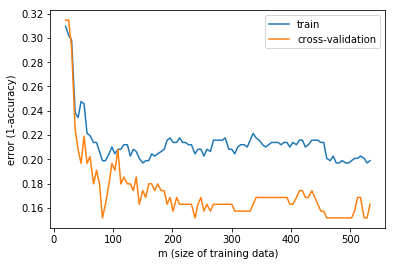

In [48]:
fig, ax = plt.subplots()
ax.plot(m_array, 1-train_acc_array, label='train')
ax.plot(m_array, 1-cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('error (1-accuracy)')

In [49]:
accuracy = lr_model.score(X_test, y_test)

print("accuracy on testing data: {:0.2f}".format(accuracy*100))

accuracy on testing data: 77.53


Now we have a model accuracy of ~80% on our testing data, which the classifier has never seen before we will apply it to the actual testing data to submit to Kaggle.

## Loading Test Data to Predict On for Kaggle Submission

In [50]:
data_kaggle_test = pd.read_csv('data/test.csv', index_col='PassengerId')
del data_kaggle_test.index.name # lets also remove this row with just the name on it to make things easier later

In [51]:
data_kaggle_test[0:5]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Preprocessing the data as we did for the training data

In [52]:
data_kaggle_test = data_kaggle_test.drop(labels=['Name', 'Ticket', 'Cabin'], axis=1) # dropping name, ticket and Cabin columns

data_kaggle_test['Age'] = imputer.fit_transform(data_kaggle_test['Age'].reshape(-1, 1))

# ----- one-hot encoding sex ----- 

data_kaggle_test['Sex_numeric'] = le_sex.transform(data_kaggle_test.Sex) # transform the data from labels to numeric


# ----- one-hot encoding Embarked ----- 

data_kaggle_test['Embarked_numeric'] = le_Embarked.transform(data_kaggle_test.Embarked) # transform the data from labels to numeric

encoded_column_vector = data_kaggle_test.Embarked_numeric.values.reshape(-1,1) # gets numeric embarked data and rehsapes it to column vector

Embarked_one_hot_encoded = enc_Embarked.transform(encoded_column_vector).toarray() # transforms the data to one-hot-encoded data

dfOneHot_Encoded = pd.DataFrame(Embarked_one_hot_encoded, 
columns = ["Embarked_"+le_Embarked.inverse_transform(int(i)) for i in range(Embarked_one_hot_encoded.shape[1])],
index=data_kaggle_test.index
) # we now construct a dataframe out of this one-hot-encoded data

data_kaggle_test = pd.concat([data_kaggle_test, dfOneHot_Encoded], axis=1)
# we now add our one-hot-encoded Embarked features

# ----- one-hot encoding Pclass ----- 

Pclass_lb = preprocessing.LabelBinarizer()
Pclass_one_hot_encoded = Pclass_lb.fit_transform(data_kaggle_test.Pclass.values)

dfOneHot_Encoded = pd.DataFrame(Pclass_one_hot_encoded, 
columns = ["Pclass_"+str(int(i+1)) for i in range(Pclass_one_hot_encoded.shape[1])],
index=data_kaggle_test.index
) # we now construct a dataframe out of this one-hot-encoded data

data_kaggle_test = pd.concat([data_kaggle_test, dfOneHot_Encoded], axis=1)
# we now add our one-hot-encoded Embarked features

data_kaggle_test.drop(labels=['Sex', 'Pclass', 'Embarked', 'Embarked_numeric'], axis=1, inplace=True) # we drop the features that we have one-hot-encoded but not removed yet (we left these in to check the encoding had worked correctly)

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [53]:
data_kaggle_test[0:5]

,Age,SibSp,Parch,Fare,Sex_numeric,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
892,34.5,0,0,7.8292,1,0.0,1.0,0.0,0,0,1
893,47.0,1,0,7.0000,0,0.0,0.0,1.0,0,0,1
894,62.0,0,0,9.6875,1,0.0,1.0,0.0,0,1,0
895,27.0,0,0,8.6625,1,0.0,0.0,1.0,0,0,1
896,22.0,1,1,12.2875,0,0.0,0.0,1.0,0,0,1


In [54]:
inds = pd.isnull(data_kaggle_test).any(1).nonzero()[0]

In [55]:
data_kaggle_test[inds[0]:inds[0]+1]

,Age,SibSp,Parch,Fare,Sex_numeric,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
1044,60.5,0,0,NaN,1,0.0,0.0,1.0,0,0,1


We didn't have a training example where the Fare was NaN so we now fit an imputer to the training data in order to impute a mean training value to use here.

In [56]:
imputer_fare = preprocessing.Imputer(strategy="mean", axis=0)
imputer_fare.fit(data['Age'].reshape(-1, 1))
data_kaggle_test['Fare'] = imputer_fare.transform(data_kaggle_test['Fare'].reshape(-1, 1))

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [57]:
data_kaggle_test

,Age,SibSp,Parch,Fare,Sex_numeric,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
892,34.50000,0,0,7.8292,1,0.0,1.0,0.0,0,0,1
893,47.00000,1,0,7.0000,0,0.0,0.0,1.0,0,0,1
894,62.00000,0,0,9.6875,1,0.0,1.0,0.0,0,1,0
895,27.00000,0,0,8.6625,1,0.0,0.0,1.0,0,0,1
896,22.00000,1,1,12.2875,0,0.0,0.0,1.0,0,0,1
897,14.00000,0,0,9.2250,1,0.0,0.0,1.0,0,0,1
898,30.00000,0,0,7.6292,0,0.0,1.0,0.0,0,0,1
899,26.00000,1,1,29.0000,1,0.0,0.0,1.0,0,1,0
900,18.00000,0,0,7.2292,0,1.0,0.0,0.0,0,0,1
901,21.00000,2,0,24.1500,1,0.0,0.0,1.0,0,0,1


### We now predict on our test data and write the predictions to a CSV file to submit to Kaggle

In [58]:
prediction_kaggle_data = lr_model.predict(data_kaggle_test)

In [59]:
data_kaggle_test.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', length=418)

In [60]:
with open('prediction_submission_LR.csv', 'w') as file:
    print('PassengerId,Survived', file=file)
    for i, id_ in enumerate(data_kaggle_test.index):
        print('{},{}'.format(id_, prediction_kaggle_data[i]), file=file)


The result is quite variable, but I get scores of 75.1%-77.5% from 4 submissions with different random train/validation/test splits.

## Lets now attempt to train a Support Vector Machine to predict surivival

### Feature scaling

We will now perform feature scaling on the continous variables, namely Age, SibSp, Parch, and Fare, such that they are all around the same scale. This wasn't so important for logistic regression but IS important for SVMs.

In [61]:
scaler_age = preprocessing.StandardScaler().fit(data['Age'].reshape(-1, 1))
data['Age'] = scaler_age.transform(data['Age'].reshape(-1, 1))

scaler_SibSp = preprocessing.StandardScaler().fit(data['SibSp'].reshape(-1, 1))
data['SibSp'] = scaler_SibSp.transform(data['SibSp'].reshape(-1, 1))

scaler_Parch = preprocessing.StandardScaler().fit(data['Parch'].reshape(-1, 1))
data['Parch'] = scaler_Parch.transform(data['Parch'].reshape(-1, 1))

scaler_Fare = preprocessing.StandardScaler().fit(data['Fare'].reshape(-1, 1))
data['Fare'] = scaler_Fare.transform(data['Fare'].reshape(-1, 1))

X_temp, X_test, y_temp, y_test = model_selection.train_test_split(X, y, test_size=0.2)

X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_temp, y_temp, train_size=0.75)

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykern

We now perform our feature scaling with the fitted scalers

In [62]:
data_kaggle_test['Age'] = scaler_age.transform(data_kaggle_test['Age'].reshape(-1, 1))

data_kaggle_test['SibSp'] = scaler_SibSp.transform(data_kaggle_test['SibSp'].reshape(-1, 1))

data_kaggle_test['Parch'] = scaler_Parch.transform(data_kaggle_test['Parch'].reshape(-1, 1))

data_kaggle_test['Fare'] = scaler_Fare.transform(data_kaggle_test['Fare'].reshape(-1, 1))

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.p

In [63]:
C = 1 # start with penalty parameter equal to 1 as we don't know what value this should take yet, larger C -> lower bias, higher variance, smaller C -> higher bias, lower varaince. Since we don't have that much data a lower bias algorithm is probably best to avoid overfitting

kernel = 'linear' # we'll start with a simple linear kernal to see how ths performs

svm_model = svm.SVC(C=C, kernel=kernel)

In [64]:
svm_model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
svm_model.score(X_cv, y_cv)

0.7415730337078652

In [66]:
C_array = np.array([0.003, 0.01, 0.02, 0.03, 0.05, 0.1, 0.3, 1, 3])
train_score_array = np.zeros_like(C_array)
validation_score_array = np.zeros_like(C_array)
for i, C in enumerate(C_array):
    print(i, C)
    svm_model = svm.SVC(C=C, kernel=kernel)
    svm_model.fit(X_train, y_train)
    train_score_array[i] = svm_model.score(X_train, y_train)
    validation_score_array[i] = svm_model.score(X_cv, y_cv)

0 0.003
1 0.01
2 0.02
3 0.03
4 0.05
5 0.1
6 0.3
7 1.0
8 3.0


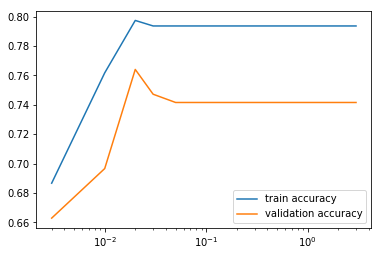

In [67]:
fig, ax = plt.subplots()
ax.plot(C_array, train_score_array, label='train accuracy')
ax.plot(C_array, validation_score_array, label='validation accuracy')
ax.semilogx()
ax.legend()

In [68]:
index_best = np.argmax(validation_score_array)
bestC = C_array[index_best]
print('C that performed best on validation data was C={}'.format(bestC))
print("train score: {:0.3f}, validation score: {:0.3f}".format(train_score_array[index_best], validation_score_array[index_best]))

C that performed best on validation data was C=0.02
train score: 0.797, validation score: 0.764


In [69]:
svm_model = svm.SVC(C=bestC, kernel=kernel)
svm_model.fit(X_train, y_train)

SVC(C=0.02, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
svm_model.score(X_test, y_test)

0.8089887640449438

We get ~80 percent accuracy on the test data we held back from our training and validation set.

Now we predict on the Kaggle data and submit to get a score.

In [71]:
prediction_kaggle_data = svm_model.predict(data_kaggle_test)

In [72]:
with open('prediction_submission_SVM_Linear_Kernel.csv', 'w') as file:
    print('PassengerId,Survived', file=file)
    for i, id_ in enumerate(data_kaggle_test.index):
        print('{},{}'.format(id_, prediction_kaggle_data[i]), file=file)


Got ~76% accuracy on Kaggle.

### Learning curve for Linear Kernal SVM with best C (0.03)

In [73]:
m_array = np.round(np.linspace(20, X_train.shape[0], 20)).astype(int)
train_acc_array = np.zeros(len(m_array))
cv_acc_array = np.zeros(len(m_array))

for i, m in enumerate(m_array):
    print(i, end=', ')
    svm_model_iter = svm.SVC(C=bestC, kernel=kernel)
    # we now fit to the training data
    svm_model_iter.fit(X_train.head(m), y_train.head(m)) # training on the first m training data examples
    train_accuracy = svm_model_iter.score(X_train, y_train)
    train_acc_array[i] = train_accuracy
    cv_accuracy = svm_model_iter.score(X_cv, y_cv)
    cv_acc_array[i] = cv_accuracy


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

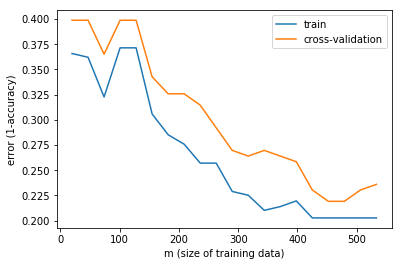

In [74]:
fig, ax = plt.subplots()
ax.plot(m_array, 1-train_acc_array, label='train')
ax.plot(m_array, 1-cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('error (1-accuracy)')

### We will now try an SVM with a Gaussian Kernal


### We will use the Gaussian radial-basis function (RBF kernel)



In [125]:
C = 1 # start with penalty parameter equal to 1 as we don't know what value this should take yet, larger C -> lower bias, higher variance, smaller C -> higher bias, lower varaince. Since we don't have that much data a lower bias algorithm is probably best to avoid overfitting

kernel = 'rbf' # we'll use the radial basis function (Gaussian) kernal to see how ths performs

gamma = 'auto' # a second hyperparameter to tune for the Guassian kernal - the width of the Gaussian function used

svm_model = svm.SVC(C=C, kernel=kernel, gamma=gamma)

In [126]:
svm_model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [127]:
svm_model.score(X_cv, y_cv)

0.5842696629213483

Not very good performance. Since we now have 2 hyperparameters to tune we will make use of scikit learns grid_search function which allows you to provide a range of values of parameters and search over the grid for the best hyperparameters.

In [129]:
svm_model = svm.SVC(kernel=kernel)
params = {"C":[0.01, 0.03, 0.1, 0.3, 1, 3, 10], "gamma": [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3]}
grid_search = model_selection.GridSearchCV(svm_model, params)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10], 'gamma': [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [130]:
bestC = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

In [131]:
svm_model = svm.SVC(C=bestC, kernel=kernel, gamma=best_gamma)
svm_model.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [132]:
svm_model.score(X_cv, y_cv)

0.651685393258427

## Now lets try a neural network